# Comparison: Constant Rate vs. Constant Pressure Injection

**Objective:** Compare two fundamental industrial injection strategies using the JAX-LaB framework.

1.  **Constant Pressure Injection (Baseline):** The inlet pressure is fixed ($P_{in} = const$). The flow rate $Q(t)$ decreases as the reservoir fills or pores clog.
2.  **Constant Rate Injection:** The inlet flow flux is fixed ($Q_{in} = const$). The pressure $P(t)$ rises as back-pressure builds up.

**Key Difference:**
* **Constant Pressure** is safe (prevents fracturing) but inefficient (injection stops if clogging occurs).
* **Constant Rate** forces fluid in but risks dangerous pressure spikes if clogging occurs.

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, lax, checkpoint
import matplotlib.pyplot as plt
import numpy as np

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# --- 1. Physical Constants (SAME CONFIG) ---
NX, NY = 100, 50       
TIME_STEPS = 1000      

TAU_BRINE = 1.0        
TAU_CO2 = 0.9          
G_INT = -1.0           
RHO_BRINE = 1.0        
RHO_CO2_INIT = 0.1     
D_SALT = 0.05          
K_SP = 1.1             

# Lattice Weights
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])

print("Environment Configured: Comparison Mode")

Environment Configured: Comparison Mode


## 2. Zou-He Boundary Conditions
To accurately simulate these two modes, we implement the **Zou-He Boundary Condition** logic for the inlet (Left Wall, $x=0$).

* **Pressure BC:** Fix $\rho_{in}$, calculate $u_{in}$ from populations.
* **Velocity BC:** Fix $u_{in}$ (Rate), calculate $\rho_{in}$ from populations.

In [2]:
@jit
def get_equilibrium(rho, u_x, u_y):
    u_x_exp = jnp.expand_dims(u_x, axis=-1)
    u_y_exp = jnp.expand_dims(u_y, axis=-1)
    rho_exp = jnp.expand_dims(rho, axis=-1)
    u_sq = u_x**2 + u_y**2
    u_sq_exp = jnp.expand_dims(u_sq, axis=-1)
    eu = (CX * u_x_exp + CY * u_y_exp)
    return rho_exp * W * (1.0 + 3.0*eu + 4.5*eu**2 - 1.5*u_sq_exp)

@jit
def interaction_force(rho, G):
    rho_safe = jnp.clip(rho, 1e-3, 5.0)
    psi = 1 - jnp.exp(-rho_safe)
    psi_xp, psi_xm = jnp.roll(psi, -1, axis=0), jnp.roll(psi, 1, axis=0)
    psi_yp, psi_ym = jnp.roll(psi, -1, axis=1), jnp.roll(psi, 1, axis=1)
    fx = -G * psi * (psi_xp - psi_xm)
    fy = -G * psi * (psi_yp - psi_ym)
    return fx, fy

@jit
def collision_stream(f, salt_conc, mask, tau):
    rho = jnp.sum(f, axis=-1)
    rho_safe = jnp.maximum(rho, 1e-3)
    u_x = jnp.sum(f * CX, axis=-1) / rho_safe
    u_y = jnp.sum(f * CY, axis=-1) / rho_safe
    u_x = jnp.clip(u_x, -0.4, 0.4)
    u_y = jnp.clip(u_y, -0.4, 0.4)
    
    fx, fy = interaction_force(rho, G_INT)
    u_x += fx / rho_safe
    u_y += fy / rho_safe
    
    precip_factor = jax.nn.sigmoid(10 * (salt_conc - K_SP)) 
    u_x *= (1.0 - precip_factor) 
    u_y *= (1.0 - precip_factor)

    f_eq = get_equilibrium(rho, u_x, u_y)
    tau_exp = jnp.expand_dims(tau, axis=-1)
    f_out = f - (f - f_eq) / tau_exp
    
    for i in range(9):
        f_out = f_out.at[..., i].set(jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0, 1)))
        
    mask_exp = jnp.expand_dims(mask, axis=-1)
    f_out = f_out * (1 - mask_exp) + f * mask_exp
    return jnp.nan_to_num(f_out, nan=0.0), rho, u_x, u_y

@jit
def zou_he_inlet_velocity(f, u_target):
    """
    Constant Rate BC: Fix u_x, Calculate rho.
    Applied at x=0 (Left Wall). Directions pointing in: 1(E), 5(NE), 8(SE)
    """
    # Known populations (streaming out of domain)
    f0, f2, f3, f4, f6, f7 = f[...,0], f[...,2], f[...,3], f[...,4], f[...,6], f[...,7]
    
    # Calculate Rho based on Fixed Velocity u_target
    # Formula: rho = (f0 + f2 + f4 + 2(f3 + f6 + f7)) / (1 - u_target)
    rho_inlet = (f0 + f2 + f4 + 2*(f3 + f6 + f7)) / (1.0 - u_target)
    
    # Zou-He Update for unknowns
    # f1 = f3 + (2/3)*rho*ux
    f1 = f3 + (2.0/3.0) * rho_inlet * u_target
    # f5 = f7 - 0.5*(f2-f4) + (1/6)*rho*ux
    f5 = f7 - 0.5*(f2 - f4) + (1.0/6.0) * rho_inlet * u_target
    # f8 = f6 + 0.5*(f2-f4) + (1/6)*rho*ux
    f8 = f6 + 0.5*(f2 - f4) + (1.0/6.0) * rho_inlet * u_target
    
    f_out = f
    f_out = f_out.at[0, :, 1].set(f1[0, :])
    f_out = f_out.at[0, :, 5].set(f5[0, :])
    f_out = f_out.at[0, :, 8].set(f8[0, :])
    
    return f_out, rho_inlet

@jit
def zou_he_inlet_pressure(f, rho_target):
    """
    Constant Pressure BC: Fix rho, Calculate u_x.
    Applied at x=0 (Left Wall).
    """
    # Known populations
    f0, f2, f3, f4, f6, f7 = f[...,0], f[...,2], f[...,3], f[...,4], f[...,6], f[...,7]
    
    # Calculate Velocity based on Fixed Rho
    # Formula: u_x = 1 - (f0 + f2 + f4 + 2(f3 + f6 + f7)) / rho_target
    sum_known = f0 + f2 + f4 + 2*(f3 + f6 + f7)
    u_inlet = 1.0 - (sum_known / rho_target)
    
    # Zou-He Update (Same formulas, but u_inlet is derived)
    f1 = f3 + (2.0/3.0) * rho_target * u_inlet
    f5 = f7 - 0.5*(f2 - f4) + (1.0/6.0) * rho_target * u_inlet
    f8 = f6 + 0.5*(f2 - f4) + (1.0/6.0) * rho_target * u_inlet
    
    f_out = f
    f_out = f_out.at[0, :, 1].set(f1[0, :])
    f_out = f_out.at[0, :, 5].set(f5[0, :])
    f_out = f_out.at[0, :, 8].set(f8[0, :])
    
    return f_out, u_inlet

## 3. Simulation Step Functions
We define two separate `lbm_step` functions for the two scenarios.

In [3]:
@checkpoint
def lbm_step_pressure_mode(carry, target_pressure_val):
    f, salt, mask = carry
    
    # --- 1. LBM Step (Collision/Stream) ---
    rho_local = jnp.sum(f, axis=-1)
    tau_eff = TAU_CO2 + (TAU_BRINE - TAU_CO2) * (rho_local - RHO_CO2_INIT)/(RHO_BRINE - RHO_CO2_INIT)
    tau_safe = jnp.maximum(tau_eff, 0.52)
    f, rho, ux, uy = collision_stream(f, salt, mask, tau_safe)
    
    # --- 2. BOUNDARY CONDITION: CONSTANT PRESSURE ---
    # We fix density (rho) at inlet
    rho_target = RHO_CO2_INIT + target_pressure_val
    f_new, u_inlet_actual = zou_he_inlet_pressure(f, rho_target)
    
    # --- 3. Salt Transport ---
    ux_s = jnp.clip(ux, -0.2, 0.2)
    uy_s = jnp.clip(uy, -0.2, 0.2)
    grad_salt_x = (jnp.roll(salt, -1, axis=0) - jnp.roll(salt, 1, axis=0)) / 2.0
    grad_salt_y = (jnp.roll(salt, -1, axis=1) - jnp.roll(salt, 1, axis=1)) / 2.0
    laplacian = (jnp.roll(salt, -1, axis=0) + jnp.roll(salt, 1, axis=0) + 
                 jnp.roll(salt, -1, axis=1) + jnp.roll(salt, 1, axis=1) - 4*salt)
    salt_new = salt + (-(ux_s * grad_salt_x + uy_s * grad_salt_y) + D_SALT * laplacian)
    salt_new = salt_new.at[0, :].set(0.0)
    salt_new = jnp.clip(salt_new, 0.0, 5.0)
    
    # --- 4. Precipitation ---
    new_precip = jax.nn.sigmoid(20 * (salt_new - K_SP))
    mask_new = jnp.maximum(mask, new_precip)
    
    # Metrics
    pore_vol = jnp.sum(1-mask_new) + 1e-6
    s_co2 = jnp.sum((rho < (RHO_BRINE + RHO_CO2_INIT)/2.0) * (1-mask_new)) / pore_vol
    
    # We track Inlet Velocity to see if it drops
    inlet_flux = jnp.mean(u_inlet_actual[0, :])
    
    return (f_new, salt_new, mask_new), (s_co2, inlet_flux)

@checkpoint
def lbm_step_rate_mode(carry, target_velocity_val):
    f, salt, mask = carry
    
    # --- 1. LBM Step ---
    rho_local = jnp.sum(f, axis=-1)
    tau_eff = TAU_CO2 + (TAU_BRINE - TAU_CO2) * (rho_local - RHO_CO2_INIT)/(RHO_BRINE - RHO_CO2_INIT)
    tau_safe = jnp.maximum(tau_eff, 0.52)
    f, rho, ux, uy = collision_stream(f, salt, mask, tau_safe)
    
    # --- 2. BOUNDARY CONDITION: CONSTANT RATE ---
    # We fix velocity (u_x) at inlet
    f_new, rho_inlet_actual = zou_he_inlet_velocity(f, target_velocity_val)
    
    # --- 3. Salt Transport ---
    ux_s = jnp.clip(ux, -0.2, 0.2)
    uy_s = jnp.clip(uy, -0.2, 0.2)
    grad_salt_x = (jnp.roll(salt, -1, axis=0) - jnp.roll(salt, 1, axis=0)) / 2.0
    grad_salt_y = (jnp.roll(salt, -1, axis=1) - jnp.roll(salt, 1, axis=1)) / 2.0
    laplacian = (jnp.roll(salt, -1, axis=0) + jnp.roll(salt, 1, axis=0) + 
                 jnp.roll(salt, -1, axis=1) + jnp.roll(salt, 1, axis=1) - 4*salt)
    salt_new = salt + (-(ux_s * grad_salt_x + uy_s * grad_salt_y) + D_SALT * laplacian)
    salt_new = salt_new.at[0, :].set(0.0)
    salt_new = jnp.clip(salt_new, 0.0, 5.0)
    
    # --- 4. Precipitation ---
    new_precip = jax.nn.sigmoid(20 * (salt_new - K_SP))
    mask_new = jnp.maximum(mask, new_precip)
    
    # Metrics
    pore_vol = jnp.sum(1-mask_new) + 1e-6
    s_co2 = jnp.sum((rho < (RHO_BRINE + RHO_CO2_INIT)/2.0) * (1-mask_new)) / pore_vol
    
    # We track Inlet Pressure to see if it spikes
    inlet_pressure = jnp.mean(rho_inlet_actual[0, :] - RHO_CO2_INIT)
    
    return (f_new, salt_new, mask_new), (s_co2, inlet_pressure)

## 4. Running the Simulations
We define inputs such that they are comparable. 
* **Constant Pressure:** $P_{in} = 0.03$ (Lattice Units)
* **Constant Rate:** $u_{in} = 0.03$ (Lattice Units)

These values are chosen to be roughly equivalent in magnitude at $t=0$.

In [4]:
# --- Initialize ---
key = jax.random.PRNGKey(55)
mask_init = jax.random.bernoulli(key, p=0.25, shape=(NX, NY)).astype(jnp.float64)
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0) 

rho_init = jnp.ones((NX, NY)) * RHO_BRINE 
u_init = jnp.zeros((NX, NY))
f_init = get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5 
state_init = (f_init, salt_init, mask_init)

# --- SCENARIO A: Constant Pressure (P = 0.03) ---
print("Running Constant Pressure Simulation...")
p_schedule = jnp.ones(TIME_STEPS) * 0.03
final_state_P, (hist_sat_P, hist_flux_P) = lax.scan(lbm_step_pressure_mode, state_init, p_schedule)

# --- SCENARIO B: Constant Rate (U = 0.03) ---
print("Running Constant Rate Simulation...")
rate_schedule = jnp.ones(TIME_STEPS) * 0.03
final_state_R, (hist_sat_R, hist_pressure_R) = lax.scan(lbm_step_rate_mode, state_init, rate_schedule)

Running Constant Pressure Simulation...
Running Constant Rate Simulation...


## 5. Results & Visualization
We compare the evolution of Saturation and the "Risk Factor" (Pressure for Rate-mode, Flow drop for Pressure-mode).

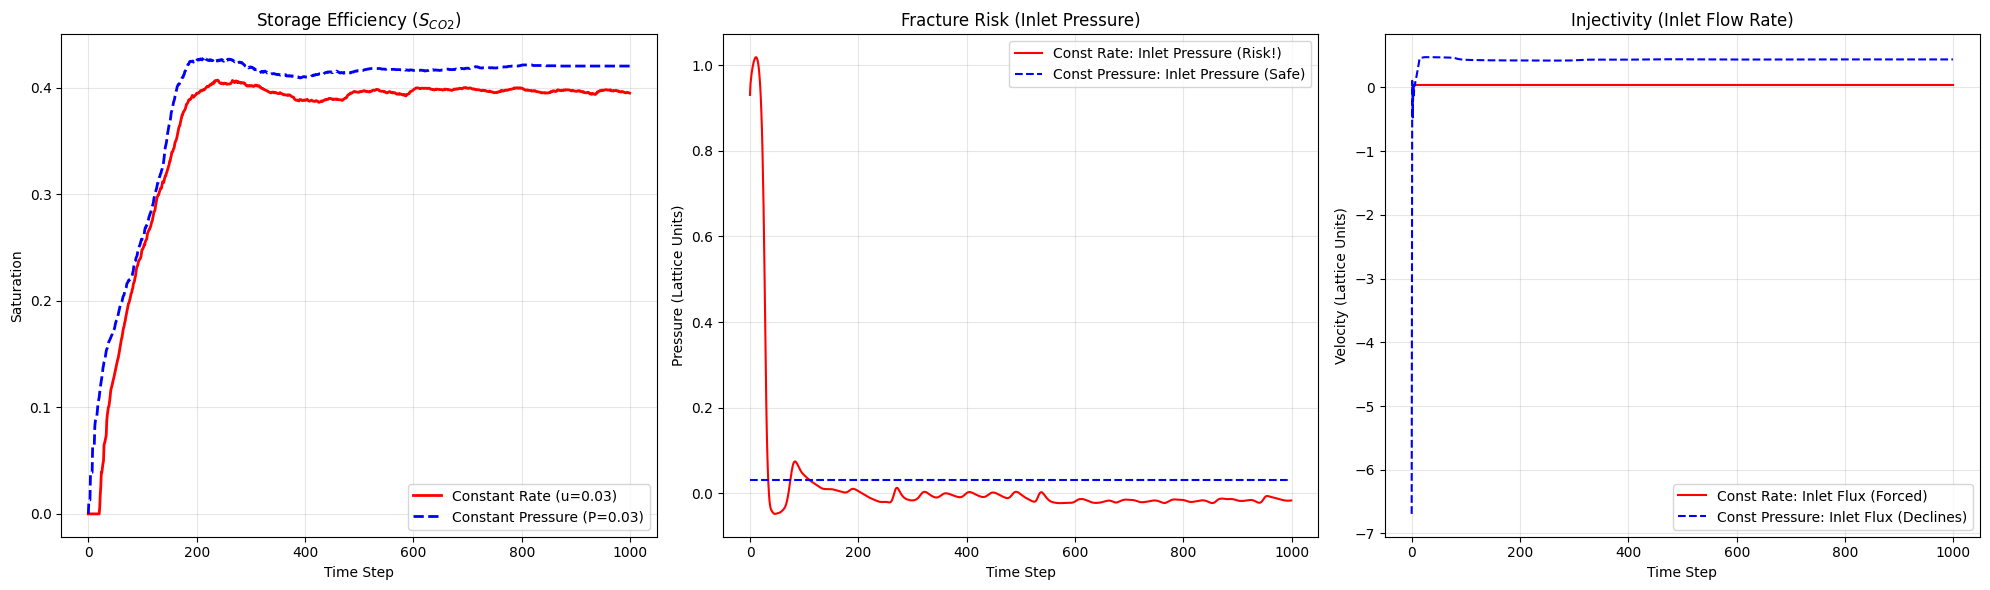

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# 1. Saturation Comparison
ax[0].plot(hist_sat_R, 'r-', linewidth=2, label='Constant Rate (u=0.03)')
ax[0].plot(hist_sat_P, 'b--', linewidth=2, label='Constant Pressure (P=0.03)')
ax[0].set_title("Storage Efficiency ($S_{CO2}$)")
ax[0].set_ylabel("Saturation")
ax[0].set_xlabel("Time Step")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Risk Analysis: Inlet Pressure
# For Const Rate, P varies. For Const Pressure, P is fixed.
ax[1].plot(hist_pressure_R, 'r-', label='Const Rate: Inlet Pressure (Risk!)')
ax[1].plot(p_schedule, 'b--', label='Const Pressure: Inlet Pressure (Safe)')
ax[1].set_title("Fracture Risk (Inlet Pressure)")
ax[1].set_ylabel("Pressure (Lattice Units)")
ax[1].set_xlabel("Time Step")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# 3. Performance Analysis: Inlet Flux
# For Const Pressure, Flux varies. For Const Rate, Flux is fixed.
ax[2].plot(rate_schedule, 'r-', label='Const Rate: Inlet Flux (Forced)')
ax[2].plot(hist_flux_P, 'b--', label='Const Pressure: Inlet Flux (Declines)')
ax[2].set_title("Injectivity (Inlet Flow Rate)")
ax[2].set_ylabel("Velocity (Lattice Units)")
ax[2].set_xlabel("Time Step")
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()